In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import functions as fc
import csv

def sensitivity(pfom_max,B_events):

    bf = 2*0.514*4.6e-6
    sigma=1.11e6 #fb
    l=100/3 #fb⁻¹
    ns=bf*sigma*l*pfom_max
    print(f"Number of sensitivity events: {ns:.2}")
    return ns/B_events



def PFOM(seff,beff,bhist,n):
    return seff/(np.sqrt(beff*sum(bhist))+n/2)





df = pq.read_table(f"/ceph/aavocone/Datasets/3_large.parquet")
df = df.to_pandas()

X = df[df.columns[:-1]]    
y = df["signal"]   




model_list = ["3_0_500","3_800","3_1000","3_1200","3_1500","3_2000"]
number_of_splits = 10



sss = StratifiedShuffleSplit(n_splits= number_of_splits)



# list to save last pfom for plotting
pfom_list = []

#list to save mean and std in
P_stat  = []
S_stat  = []  
x_stat  = []

for models in model_list:
    
    # list to calculate the mean and std
    PFOM_max     =  np.zeros(number_of_splits)
    S_max       =  np.zeros(number_of_splits)
    xgb_max      =  np.zeros(number_of_splits)
    n = 0

    clf = XGBClassifier()
    clf.load_model(f"/ceph/aavocone/models/{models}.txt")


    for train_index, test_index in sss.split(X, y):
        print("M0del:",models)
        print("Shuffle split iteration:", n+1)
        xtest = X.iloc[test_index]
        ytest = y.iloc[test_index]

        yprob = clf.predict_proba(xtest)[:,1]
        sh,bh,s,b,bin_edges = fc.efficiency(yprob,ytest)

        #get PFOM
        pfom = fc.PFOM(s,b,bh,5)
        
        #get max values
        max_index = np.where(pfom==max(pfom))[0][0] #np.where = tuple(array[index_value]), to get index you need to specify location in tuple and in array... 
        b_max = bh >= max_index/100
        b_max = b_max[b_max!=0]
        S = sensitivity(pfom[max_index],len(b_max))

        #save values in list to later calculate the mean and std
        PFOM_max[n] = pfom[max_index]
        S_max[n]    = S
        xgb_max[n]  = bin_edges[max_index]

        print("Pfom_max:")
        print(PFOM_max)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        
        n += 1

    pfom_list.append(pfom)

    # calculate statistics
    P_stat.append([np.mean(PFOM_max),np.std(PFOM_max)])
    S_stat.append([np.mean(S_max),np.std(S_max)])
    x_stat.append([np.mean(xgb_max),np.std(xgb_max)])
 




/work/aavocone/anaconda3/envs/Bachelor/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


M0del: 3_0_500
Shuffle split iteration: 1
Number of sensitivity events: 0.13
Pfom_max:
[0.00071526 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
M0del: 3_0_500
Shuffle split iteration: 2
Number of sensitivity events: 0.13
Pfom_max:
[0.00071526 0.00071544 0.         0.         0.         0.
 0.         0.         0.         0.        ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
M0del: 3_0_500
Shuffle split iteration: 3
Number of sensitivity events: 0.12
Pfom_max:
[0.00071526 0.00071544 0.00070566 0.         0.         0.
 0.         0.         0.         0.        ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
M0del: 3_0_500
Shuffle split iteration: 4
Number of sensitivity events: 0.13
Pfom_max:
[0.00071526 0.00071544 0.00070566 0.00074119 0.         0.
 0.         0.         0.         0.        ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
M0del: 3_0_500
Shuffle split iteration: 5
Number of sensitivity events: 0.12
Pfo

## PFOM plot


test: [0.0007118166368574135, 2.1240849851671712e-05]


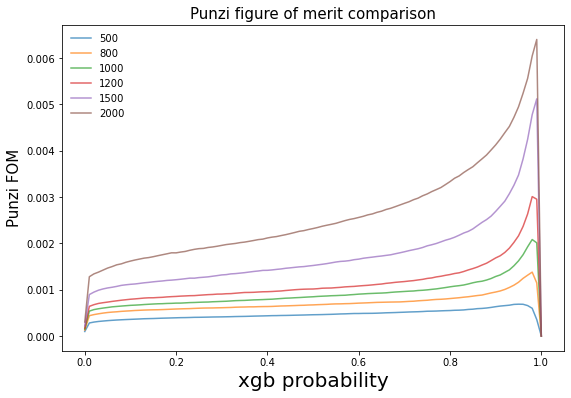

In [23]:
legends =["500","800","1000","1200","1500","2000"]


print("test:", P_stat[0])

plt.figure(figsize=(9,6))

plt.plot(bin_edges, pfom_list[0], label = legends[0], alpha = 0.7)
#plt.errorbar(x_stat[0][0], P_stat[0][0],xerr = x_stat[0][1], yerr = P_stat[0][1],color = "r")

plt.plot(bin_edges, pfom_list[1], label = legends[1], alpha = 0.7)
#plt.errorbar(x_stat[1][0], P_stat[1][0],xerr = x_stat[1][1], yerr = P_stat[1][1],color = "r")

plt.plot(bin_edges, pfom_list[2], label = legends[2], alpha = 0.7)
#plt.errorbar(x_stat[2][0], P_stat[2][0],xerr = x_stat[2][1], yerr = P_stat[2][1],color = "r")

plt.plot(bin_edges, pfom_list[3], label = legends[3], alpha = 0.7)
#plt.errorbar(x_stat[3][0], P_stat[3][0],xerr = x_stat[3][1], yerr = P_stat[3][1])

plt.plot(bin_edges, pfom_list[4], label = legends[4], alpha = 0.7)
#plt.errorbar(x_stat[4][0], P_stat[4][0],xerr = x_stat[4][1], yerr = P_stat[4][1])


plt.plot(bin_edges, pfom_list[5], label = legends[5], alpha = 0.7)
#plt.errorbar(x_stat[5][0], P_stat[0][0],xerr = x_stat[5][1], yerr = P_stat[5][1])


plt.title("Punzi figure of merit comparison",fontsize=15)
plt.ylabel("Punzi FOM",fontsize=15)
plt.xlabel("xgb probability", fontsize = 20)
plt.legend(framealpha = 0)
plt.savefig(f"/work/aavocone/week15/pfom/PFOM_3_all.pdf", format="pdf",bbox_inches="tight")
plt.show()

## Sensitivity plot

In [20]:
for i in range(len(legends)):
    print()
    print("Number of trees:", legends[i])
    print("Sensitivity:", S_stat[i][0],"+-",S_stat[i][1])
    


Number of trees: 500
Sensitivity: 3.6711435355111094e-06 +- 5.949386497050171e-07

Number of trees: 800
Sensitivity: 4.547769829500949e-05 +- 9.935457979768791e-06

Number of trees: 1000
Sensitivity: 0.00011909328217585402 +- 2.1955448344296407e-06

Number of trees: 1200
Sensitivity: 0.0007592514111137959 +- 0.0003734311323545153

Number of trees: 1500
Sensitivity: 0.003920321628722798 +- 0.0002206594264272879

Number of trees: 2000
Sensitivity: 0.0201016231114545 +- 0.0026285834793975445


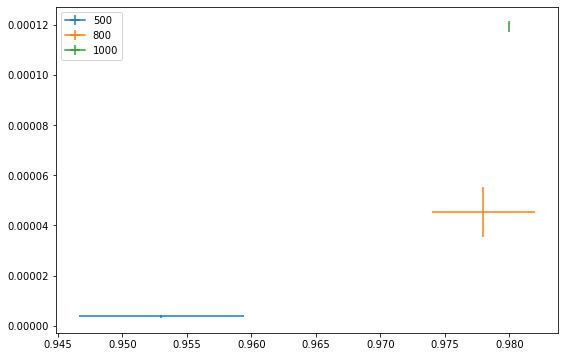

In [16]:

plt.figure(figsize=(9,6))

#plt.plot(bin_edges, pfom_list[0], label = legends[0], alpha = 0.7)
plt.errorbar(x_stat[0][0], S_stat[0][0],xerr = x_stat[0][1], yerr = S_stat[0][1], label = legends[0])

#plt.plot(bin_edges, pfom_list[1], label = legends[1], alpha = 0.7)
plt.errorbar(x_stat[1][0], S_stat[1][0],xerr = x_stat[1][1], yerr = S_stat[1][1], label = legends[1])

#plt.plot(bin_edges, pfom_list[2], label = legends[2], alpha = 0.7)
plt.errorbar(x_stat[2][0], S_stat[2][0],xerr = x_stat[2][1], yerr = S_stat[2][1], label = legends[2])

plt.legend()